In [1]:
import numpy as np
import torch
import torch.nn as nn
import time 
import logging
import torch.optim as optim
import os
from scipy.stats import multivariate_normal as normal
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import Parameter
import matplotlib.pyplot as plt
import torchvision
import matplotlib.gridspec as gridspec

# 1. WGANs, a quick introduction

When one wants to find an approximation of some probability distribution to an existing one, different metrics can be used. For example, the K-L divergence, the Jensen-Shannon divergence and the Wasserstein distance. The Wasserstein distance is preferred in this case because convergence is only in the weak sense (convergecen is easier). 

The WGANs uses the Wasserstein metric as the distance between two distributions, and for W-1, it takes the following form: 
$$W(\mathbb{P}_r,\mathbb{P}_g) = \inf_{\gamma \in \Pi(\mathbb{P}_r,\mathbb{P}_g)} \mathbb{E}_{(x,y) \sim \gamma}[||x-y||]$$
where $\gamma$ is a probability distribution whose marginals are $\mathbb{P}_r$ and $\mathbb{P}_g$. 

However, searching for the optimal distribution in a particular space is difficult. 

To address this challenge numerically, there is an interesting duality relationship that will achieve the same goal (Kantorovich-Rubinsten). 

We would love to point out that this is a linear programming problem, and the difficulty only lies in the fact that the space is infinite dimensional (function space). We will prove this duality relationship in the next section, and borrow a finite dimensional example from [2] as illustration. An implementation of a real example will be presented in the last section. 


$$W(\mathbb{P}_r,\mathbb{P}_g) = \sup_{||f||_L \leq 1 } \mathbb{E}_{x \sim \mathbb{P}_r}[f(x)] - \mathbb{E}_{x \sim \mathbb{P}_{\theta}}[f(x)]$$

Notice that, we can acutally replace Lipschitz constant 1 with a more general finite value $K$. Then suppose we have a family of functions indexed by $\omega$: $\lbrace f_{\omega}\rbrace$ that are all K-lipschitz, then the problem turns into
$$ \max_{\gamma \in \Omega} \mathbb{E}_{x \sim \mathbb{P}_r}[f_{\omega}(x)] -\mathbb{E}_{z \sim \mathbb{P}(z)}[f_{\omega}(g_{\theta}(z))]$$

where $g_{\theta}$ plays the role of the generator and $f_{\omega}$ plays the role of a discriminator. 
One can actually do backpropagation on the parameter $\theta$ and obtain the following: 
$$\nabla_{\theta} W(\mathbb{P}_r,\mathbb{P}_g)=-\mathbb{E}_{z\sim p(z)}[\nabla_{\theta}f(g_{\theta}(z))]$$

The fact that the derivatives can be taken comes from the fact that the optimality can be achieved and the assumption that both the function $f_{\omega}$ and $g_{\theta}$ are Lipschitz (Rademacher), see the proof in [1]. 

Then, based on the above description, the following algorithm is proposed [1]. 

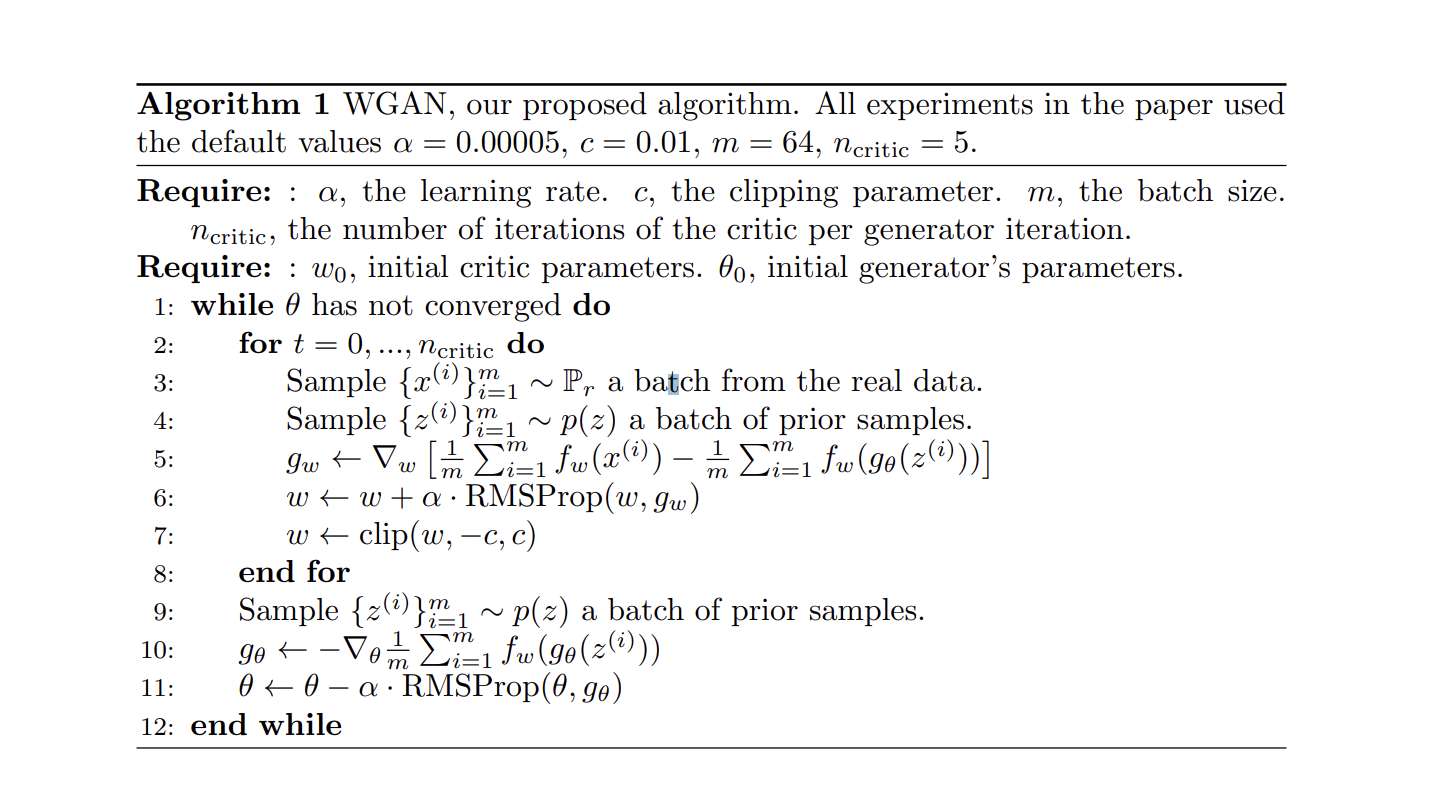

## 2. Proof of Kantorovich-Rubinstein

Now we use more generic distribution $\mu$ and $\nu$ in place of $\mathbb{P}_r,\mathbb{P}_g$.
We relax the constraint that $\gamma \in \Pi(\mu,\nu)$ but replace it with some penality 
$$W(\mu,\nu) = \inf_{\gamma \in M_+(X\times Y)} \mathbb{E}(||X-Y||)+\sup_{f,g}
\int f d\mu(x) +\int gd\nu(y) - \int f(x)+g(y) d\gamma(x,y) \tag{1} \label{eq1} $$
where $f \in L_1(\mu), g \in L_1(\nu)$.
Observe that if $\gamma \notin \Pi(\mu,\nu)$ then we can find $f,g$ concentrated at the mass at difference and make the sup in (\ref{eq1})  blow up. 

Taking the sup inside and use the Minimax principle (Rockafeller), we obtain the following:
$$
\begin{align}
W(\mu,\nu) & = \inf_{\gamma \in M_+(X\times Y)}\sup_{f,g} \int ||x-y||-f(x)-g(y) d\gamma(x,y) +
\int f d\mu(x) +\int gd\nu(y)  \\
&=\sup_{\substack{f,g}\\ f+g \leq ||x-y||}
\int f d\mu(x) +\int gd\nu(y)
\end{align}
 $$
 
This is the most general case that also applies to other space of Wasserstein metrics e.g. $W_2$. However, the constraint $f(x)+g(y)\leq ||x-y||$ is a special case. 

From the contraint, we know that 
$$f(x) \leq \inf_y\lbrace ||x-y|| -g(y)\rbrace$$
then, we have the following: 
$$
\begin{equation}
\sup_{f}
\int f d\mu(x) +\int f^c d\nu(y)
\end{equation}
$$
We know that the optimal functions can be obatained through some existence theory [3]. 

Since both $\mu, \nu$ are probability measures, we can find a large Compact set with arbitrary measure in the farfield. Then, this $L1$ function can be approximated by continous function then 1-Lipshitz function. Hence, we may only consider the case for 1-Lip function. 

We know that the c-transform of a function $f$ preseves the 1-Lip property [3]. Suppose that $f^c(y)=||x-y||-f(x)$ for some $x \in \mathbb{R}^d$
Then we have:
$$
\begin{align}
&|f^c(y)-f^c(x)| \leq ||y-x||  \ \ (\text{1-Lipschitz}) \\ 
&\Rightarrow -||x-y|| \leq f^c(y)-f^c(x) \leq ||x-y|| \\
&\Rightarrow -f^c(x) \leq ||x-y||-f^c(y) \tag{2}\label{eq2}
\end{align}
$$

Then again, by the c-transform, we have 
$$
\begin{align}
& -f^c(x) \leq \inf_y \lbrace ||x-y|| -f^c(y) \rbrace \leq -f^c(x) \\ 
\end{align}
$$
where the first inequality above comes from \eqref{eq2}, and the second inequality is obtained by setting $y= x$.
Since $\inf_y \lbrace ||x-y|| -f^c(y) \rbrace= f^{cc}(x)=f(x)$, 
we know that $f^c=-f$. 

And the claim is proved.


## 3. Finite dimensional insight (ref [2])

#### Simple finite dimensional case. Cute little code borrowed from [2]. 
In the finite dimensional case, one has

$$W(\mathbb{P}_r,\mathbb{P}_{\theta}) = \inf_{\gamma}\mathbb{E}_{\gamma}[||X-Y||] = \inf_{\Gamma} <\Gamma, D> \tag{3} \label{eq3}$$

where $\Gamma=\gamma(x,y)$ and $D=||x-y||$. Notice that in this case, D is a matrix whose element is the distance between each each $x_i$ and $y_i$.


P_r:


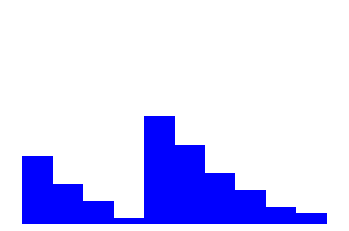

P_t:


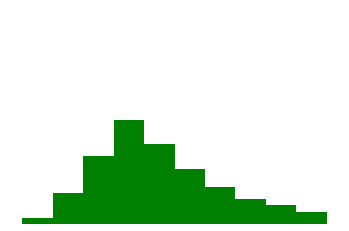

In [12]:
### total 10 mass points.

l = 10

P_r = np.array([12,7,4,1,19,14,9,6,3,2])
P_t = np.array([1,5,11,17,13,9,6,4,3,2])
P_r = P_r / np.sum(P_r)
P_t = P_t / np.sum(P_t)

plt.bar(range(l), P_r, 1, color='blue', alpha=1)
plt.axis('off')
plt.ylim(0, 0.5)
print("P_r:")
plt.show()

plt.bar(range(l), P_t, 1, color='green', alpha=1)
plt.axis('off')
plt.ylim(0, 0.5)
print("P_t:")
plt.show()

Notice that this is a typical convex linear programming problem: one wants to minimize the cost $z=c^Tx$ subject to some certain linear constraints (Ax=b). In this case, for the consideration of dimensions, we need to stack up the rows/columns in the matrix to make it a vector. 
$$x=vec(\Gamma), c=vec(D), b=[\mathbb{P}_r,\mathbb{P}_{\theta}]$$

<img src="matrix_mult.png" width="600" height="500">

Once this simple concatenation step is done, one can use the standard linear programming function to carry out the optimization.

The following is a snnipet from https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html
<img src="linprog_doc.png" width="600" height="500">

In [14]:
D = np.ndarray(shape=(l, l))

for i in range(l):
    for j in range(l):
        D[i,j] = abs(range(l)[i] - range(l)[j])

A_r = np.zeros((l, l, l))
A_t = np.zeros((l, l, l))

for i in range(l):
    for j in range(l):
        A_r[i, i, j] = 1
        A_t[i, j, i] = 1

A = np.concatenate((A_r.reshape((l, l**2)), A_t.reshape((l, l**2))), axis=0)
print("A: \n", A, "\n")

b = np.concatenate((P_r, P_t), axis=0)
c = D.reshape((l**2))

A: 
 [[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]] 



EMD:  0.7062374245525663 

Gamma:


C:\Users\huisu\anaconda3\envs\gputest2\lib\site-packages\ipykernel_launcher.py:4: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  after removing the cwd from sys.path.


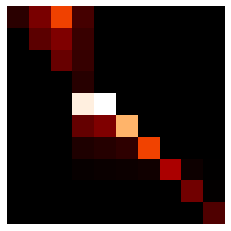

D:


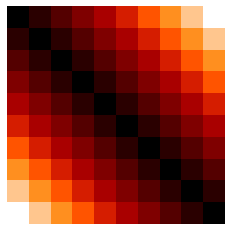

In [18]:
from scipy.optimize import linprog
from matplotlib import cm

opt_res = linprog(c, A_eq=A, b_eq=b, bounds=[0, None])
emd = opt_res.fun
gamma = opt_res.x.reshape((l, l))
print("EMD: ", emd, "\n")

plt.imshow(gamma, cmap=cm.gist_heat, interpolation='nearest')
plt.axis('off')
print("Gamma:")
plt.show()

plt.imshow(D, cmap=cm.gist_heat, interpolation='nearest')
plt.axis('off')
print("D:")
plt.show()

### The dual form

For such problem, one has the following dual form: 
<img src="finite_dual.png" width="600" height="500">
Here the cost function directly depends on the marginal distribution $b$. 
For the discussion between the strong and weak duality, see the reference [2].

Now, the optimal $y^*=[f,g]$ is of interest, where $f \in \mathbb{P}_r$ and $g \in \mathbb{P}_{\theta}$, and one can simply use `linprog` in the following way.


dual EMD:  0.7062374154981339
f: 
 [ 0.91470897 -0.08529103 -1.08529103 -2.08529105 -1.08529102 -0.08529102
  0.91470897  1.91470893  0.91470901 -0.085291  ]


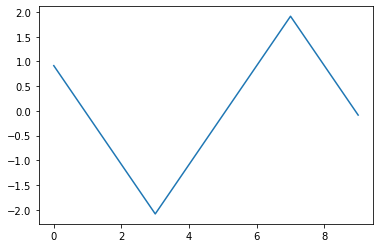

g: 
 [ 0.91470897 -0.08529103 -1.08529103 -2.08529105 -1.08529102 -0.08529102
  0.91470897  1.91470893  0.91470901 -0.085291  ]


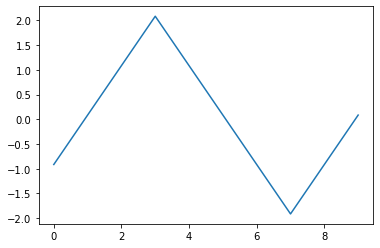

In [19]:
opt_res = linprog(-b, A.T, c, bounds=(None, None))

emd = -opt_res.fun
f = opt_res.x[0:l]
g = opt_res.x[l:]

#print(dual_result)
print("dual EMD: ", emd)

print("f: \n", f)
plt.plot(range(l), f)
plt.savefig("f_function.svg")
plt.show()


print("g: \n", f)
plt.plot(range(l), g)
plt.show()

## 4. A simple implementation of WGANs

In [2]:
data_type=torch.float32
MOMENTUM = 0.99
EPSILON = 1e-6

In [3]:
(x_train, y_train), (x_test, y_test) =tf.keras.datasets.mnist.load_data()
x_train = x_train.astype(np.float32).reshape(-1, 28*28) / 255.0
x_test = x_test.astype(np.float32).reshape(-1, 28*28) / 255.0

In [4]:
class Config(object):
    gen_layer=4
    img_flatsize=1*28*28
    z_size=10
    gen_hidden=[z_size,128,img_flatsize]
    dis_hidden=[img_flatsize,128,1]

In [5]:
class Dense(nn.Module):
    def __init__(self,cin,cout,batch_norm=False,activate=True):
        super(Dense,self).__init__()
        self.cin=cin
        self.cout=cout
        self.activate=activate
        self.actF=nn.LeakyReLU(0.2, inplace=True);
        self.batch_norm=batch_norm
        
        self.linear=nn.Linear(self.cin,self.cout)## The linear layer
        if self.batch_norm:
            self.bn=nn.BatchNorm1d(cout,eps=EPSILON,momentum=MOMENTUM)
        else:
            self.bn=None
            
    def forward(self,xin):
        x=torch.clone(xin)
        x=self.linear(x)
        if self.bn is not None:
            x=self.bn(x)
        if self.activate:
            x=self.actF(x)
        return x  

In [6]:
class Generator(nn.Module):
    def __init__(self,config):
        super(Generator,self).__init__()
        self.config=config
        
        self.bn=nn.BatchNorm1d(self.config.gen_hidden[0],eps=EPSILON,momentum=MOMENTUM)
        self.layers=[Dense(self.config.gen_hidden[i-1],config.gen_hidden[i]) for i in range(1, len(self.config.gen_hidden)-1)]
        self.layers+=[Dense(self.config.gen_hidden[-2], self.config.gen_hidden[-1],activate=False)]
        self.layers=nn.Sequential(*self.layers)
        
    def forward(self,xin):
        #xin is the artificial 
        x=torch.clone(xin)
      #  x=self.bn(x)
        x=self.layers(x)
        x=torch.sigmoid(x)
        return x

In [7]:
class Discriminator(nn.Module):
    def __init__(self,config):
        super(Discriminator,self).__init__()
        self.config=config
        
        self.bn=nn.BatchNorm1d(self.config.dis_hidden[0],eps=EPSILON,momentum=MOMENTUM)
        self.layers=[Dense(self.config.dis_hidden[i-1],config.dis_hidden[i]) for i in range(1, len(self.config.dis_hidden)-1)]
        self.layers+=[Dense(self.config.dis_hidden[-2], self.config.dis_hidden[-1],activate=False)]
        self.layers=nn.Sequential(*self.layers)
        
    def forward(self,xin):
        x=torch.clone(xin)
      #  x=self.bn(x)
        x=self.layers(x)
        return x

In [8]:
mb_size = 32
z_dim = 10
X_dim = x_train.shape[1]
y_dim = y_train.shape[0]
h_dim = 128
cnt = 0
lr = 1e-4
cfg=Config()


G =Generator(cfg)
D=Discriminator(cfg)



def reset_grad():
    G.zero_grad()
    D.zero_grad()


G_solver = optim.RMSprop(G.parameters(), lr=lr)
D_solver = optim.RMSprop(D.parameters(), lr=lr)

In [ ]:
for it in range(1000000):
    for _ in range(5):
        # Sample data
        z = Variable(torch.randn(mb_size, z_dim))
       # X, _ = mnist.train.next_batch(mb_size)
        idx=np.random.choice(60000, mb_size); 
        X=x_train[idx]; 
        X = Variable(torch.from_numpy(X))

        # Dicriminator forward-loss-backward-update
        G_sample = G(z)
        D_real = D(X)
        D_fake = D(G_sample)

        D_loss = -(torch.mean(D_real) - torch.mean(D_fake))

        D_loss.backward()
        D_solver.step()

        # Weight clipping
        for p in D.parameters():
            p.data.clamp_(-0.01, 0.01)

        # Housekeeping - reset gradient
        reset_grad()

    # Generator forward-loss-backward-update
    id2=np.random.choice(60000, mb_size);
    X = x_train[id2]
    X = Variable(torch.from_numpy(X))
    z = Variable(torch.randn(mb_size, z_dim))

    G_sample = G(z)
    D_fake = D(G_sample)

    G_loss = -torch.mean(D_fake)

    G_loss.backward()
    G_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

    # Print and plot every now and then
    if it % 1000 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'
              .format(it, D_loss.data.numpy(), G_loss.data.numpy()))

        samples = G(z).data.numpy()[:16]

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        if not os.path.exists('out2/'):
            os.makedirs('out2/')

        plt.savefig('out2/{}.png'.format(str(cnt).zfill(3)), bbox_inches='tight')
        cnt += 1
        plt.close(fig)

## References
\[1\] Martin Arjovsky etl. [Wasserstein GAN](https://arxiv.org/abs/1701.07875).

\[2\] Vincent Herrmann. [Wasserstein GAN and the Kantorovich-Rubinstein Duality](https://vincentherrmann.github.io/blog/wasserstein/)

\[3\] Filippo Santambrogio. [Optimal Transport for Applied Mathematicians: Calculus of Variations, PDEs, and Modeling](https://link.springer.com/book/10.1007/978-3-319-20828-2)